In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
np.random.seed(2020)

## Load and explore data:

The 3D matrix contains our typical contrast-defined bar stimulus on a mean-luminance background. The dimensions of the 3D matrix are ‘visual space’ x ‘visual space’ x ‘time’. Visual space dimensions are **5 degrees of visual angle (radius) from central fixation**, i.e. 10 x 10 degrees total, and every time-point is separated by **1.5 seconds**.

In [2]:
# load data
fname = 'images.npz'
with np.load(fname) as dobj:
    data = dict(dobj)

stim = data['ims'].T
stim.shape

(240, 600, 600)

<ipython-input-3-167bef0526eb>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


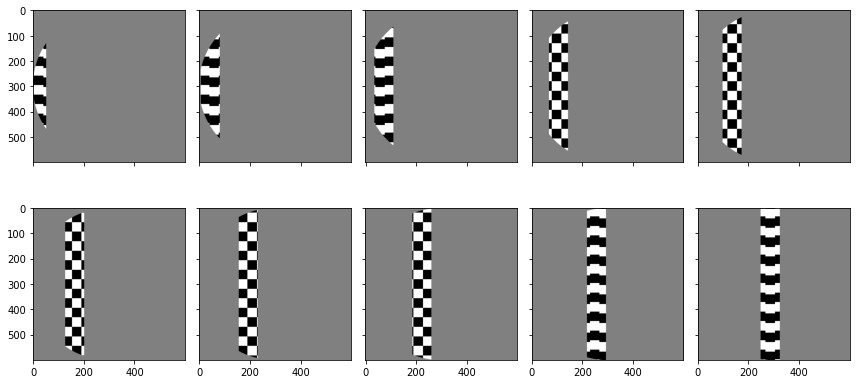

In [3]:
# plot first 10 stimulus bars
fig, axs = plt.subplots(2,5, figsize=(12,6), sharex=True, sharey=True)
for ax, im in zip(axs.flat, stim):
    ims = ax.imshow(im, cmap="gray")

fig.tight_layout()
fig.show()

### Stimulus pre-processing:
Only binary mask of stimulus is needed for the model.

In [4]:
# get value of mean luminance 
background = stim.mean().round()

# binarize stimulus
bin_stim = stim - background
bin_stim[bin_stim != 0] = 1 

---
## Question 1:
Please create a (Gaussian) population receptive field (pRF) at 2 degrees eccentricity (polar-angle up to you) with a size (standard deviation or sigma) of 1 degree, and generate the predicted fMRI time-series given the stimulus described above.

In [34]:
# define functions that will be used to create pRF model and to predict fMRI response

def pRF_model(x0,y0,sig,im_shape=600,plot=True, add_labels=False):
    """Creates 2D-gaussian population receptive field (pRF), with a centre
    x0, y0 and a spread of sig.

    Args:
      x0 (int) : centre of gaussian in x-direction
      y0 (int) : centre of gaussian in y-direction
      sig (int) : spread of the gaussian
      im_shape (int) : length of image
      plot (bool) : if True plot pRF model
      
    Returns:
      pRF (array) : 2D guassian pRF as defined in Dumoulin and Wandell (2008)
    """
    s = np.arange(-int(im_shape/2),int(im_shape/2),1) # number of pixels
#     s = np.arange(1,im_shape+1,1) # number of pixels
    pRF = [] # initialize array of final pRF
    
    # calculate pRF value for each coordinate in visual space 
    for y in s:
        for x in s:
            g = np.exp(-((x-x0)**2 + (y-y0)**2)/(2*sig**2))
            pRF.append(g)

    pRF = np.array(pRF).reshape(im_shape,im_shape)
    
    if plot:
        fig,ax=plt.subplots(1,1,figsize=(4,4))

        ax.set_yticks([])
        ax.set_xticks([])

        ax.pcolormesh(pRF)
        ax.set_aspect('equal')
        if add_labels:
            ax.set_title('pRF model')
            plt.xlabel('x-axis')
            plt.ylabel('y-axis')
            plt.colorbar()
    
    return pRF

def predict_BOLD(bin_stim, pRF, plot=True):
    """ Predicts fMRI timeseries response from stimulus-driven pRF.
    Args:
      bin_stim (3d array) : array of binarized stimuli presented (time x x_axis x y_axis)
      pRF (2d array) : 2D guassian stimulus-driven pRF
      plot (bool) : if True plot predicted fMRI timeseries
      
    Returns:
      pred_bold (array) : predicted response at each timepoint of stim
    """    
    pred_bold = [] # intialize
    
    # predict response for each timepoint 
    for t in range(len(bin_stim)):
        b = np.sum(bin_stim[t]*pRF)
        pred_bold.append(b)
    
    pred_bold = np.array(pred_bold)
    
    if plot:
        plt.figure()
        plt.title('Predicted Response Timeseries')
        plt.xlabel('Time')
        plt.ylabel('Predicted BOLD')
        plt.plot(pred_bold)
        plt.show()
    
    return pred_bold

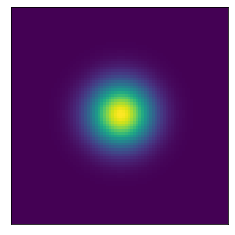

In [35]:
r = pRF_model(0, 0, 0.5*16,im_shape=5*16)

### Parameter selection:
Since the full length of one image (600 pixels) is 10 degrees of visual angle, 60 pixels is 1 degree. As a result, to represent an eccentricity of 2 the coordinates (420,300) were chosen for $(x_{0},y_{0})$. For a sigma of 1, 60 is used.

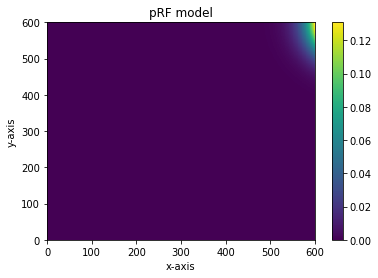

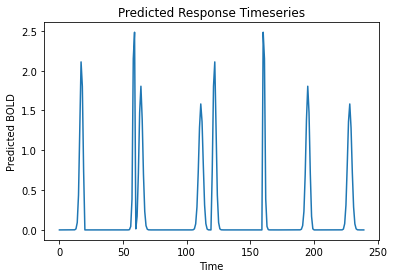

In [11]:
pRF = pRF_model(420,300,60)
bold = predict_BOLD(bin_stim, pRF)

---
## Question 2:

Please describe **how the predicted fMRI time-series change with attention**. We realize that there are many effects of attention described, and we recommend to focus only on a small subset or even one type of effect rather than being all-inclusive.

---
Gaussian interaction models are used to predict this re-weighting of stimulus-driven pRFs in response to an attention field (Klien et al., 2014). Below I simulate normal distributions to test the effects of attention by implementing a gaussian interaction model (Klien et al., 2014; Klien et al., 2018).

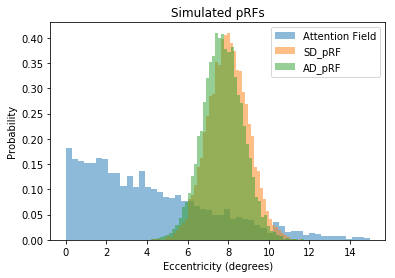

In [14]:
# simulate data
muAF= -2
mupRF= 8
sigAF= 6
sigpRF= 1

AF_dist = np.random.normal(muAF,sigAF,10000)
AF_dist = AF_dist[(AF_dist>0)&(AF_dist<15)]
pRF_dist = np.random.normal(mupRF,sigpRF,10000)


# multiply gaussians to get a gaussian representing pRF under influence of attention (Klien et al., 2014)
mu_final = ((muAF*sigpRF**2) + (mupRF*sigAF**2))/(sigAF**2+sigpRF**2)
sig_final = (sigAF**2 * sigpRF**2)/(sigAF**2 + sigpRF**2)
final_dist = np.random.normal(mu_final, sig_final, 10000)

# plot simulated gaussians
plt.figure()
plt.title('Simulated pRFs')
plt.xlabel('Eccentricity (degrees)')
plt.ylabel('Probability')
plt.hist(AF_dist, density=True, alpha=.5, bins=50, label='Attention Field')
plt.hist(pRF_dist, density=True, alpha=.5, bins=50, label='SD_pRF')
plt.hist(final_dist, density=True, alpha=.5, bins=50, label='AD_pRF')
plt.legend()
# plt.savefig('pRFs_attention.png',dpi=300)
plt.show()

Guassian interaction model results in a shift of the mean of the resulting pRF. 

Next, examine what happens to predicted fMRI timeseries (from above), if the eccentricity used is 4 instead of 2.

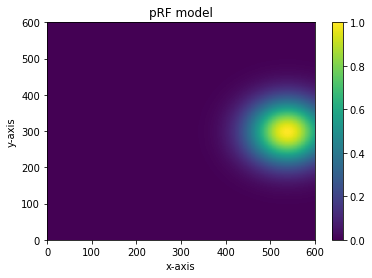

In [8]:
# first create new pRF model based on an eccentricity shift
pRF_AD = pRF_model(540,300,60)
bold_AD = predict_BOLD(bin_stim, pRF_AD, plot=False)

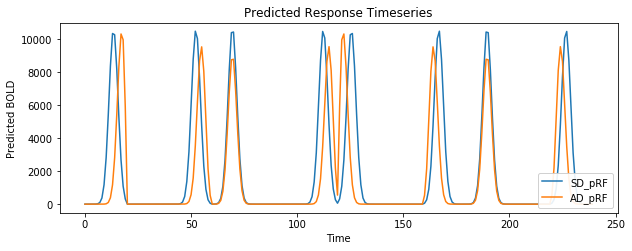

In [9]:
# plot old predicted BOLD (only stimulus driven) and new predicted BOLD (stimulus and attention driven)
plt.figure(figsize=(10,3.5))
plt.title('Predicted Response Timeseries')
plt.xlabel('Time')
plt.ylabel('Predicted BOLD')
plt.plot(bold, label='SD_pRF')
plt.plot(bold_AD, label='AD_pRF')
plt.legend(loc='lower right', framealpha=0.9)
# plt.savefig('Predicted Response Timeseries.png', dpi=300)
plt.show()

---
## References

1. Dumoulin SO, Wandell BA (2008) Population receptive field estimates in human visual cortex. NeuroImage 39:647–660.
2. Klein BP, Harvey BM, Dumoulin SO (2014) Attraction of Position Preference by Spatial Attention throughout Human Visual Cortex. Neuron 84:227–237. 
3.	Klein BP, Fracasso A, van Dijk JA, Paffen CLE, te Pas SF, Dumoulin SO (2018) Cortical depth dependent population receptive field attraction by spatial attention in human V1. NeuroImage 176:301–312.
---

## Supplementary

Since pRF model and effective stimulus are defined in the same units of visual space we can visualize the pRF response to a given stimulus.

In [10]:
def plot_pRF_response(stim_id, bin_stim, pRF, plot=True):
    """ Predicts fMRI timeseries response from stimulus-driven pRF.
    Args:
      bin_stim (3d array) : array of binarized stimuli presented (time x x_axis x y_axis)
      pRF (2d array) : 2D guassian stimulus-driven pRF
      
    Returns:
      pred_bold (array) : predicted response at each timepoint of stim
    """  
    # plot example binarized stimulus and example pRF response 
    
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111) 
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    sides = ['left', 'right', 'top', 'bottom']
    for i in sides:
        ax.spines[i].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')

    ax1.pcolormesh(pRF, cmap="gray")
    ax1.set_title('pRF model')

    ax2.pcolormesh(bin_stim[stim_id], cmap="gray")
    ax2.set_title(f'Binirized Stimulus {stim_id}')

    a3 = ax3.pcolormesh(bin_stim[stim_id] * pRF, cmap="gray")
    ax3.set_title(f'pRF Response to Stimulus {stim_id}')

    plt.colorbar(a3)

    plt.tight_layout()
#     plt.savefig('pRF_response.png', dpi=300)
    plt.show()

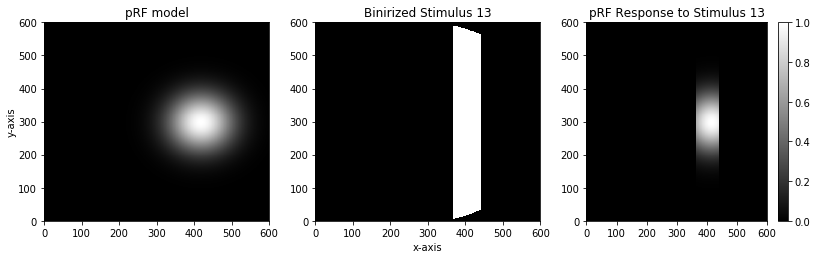

In [11]:
plot_pRF_response(13,bin_stim,pRF)